In [1]:
# %pip install seaborn
# %pip install scikit-learn

### Étape 1 : Importer les Bibliothèques

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np


### Étape 2 : Préparer les Données
Nous allons utiliser un petit jeu de données français-anglais pour créer nos vocabulaires et préparer les tenseurs pour l'entraînement.

2.1 Dataset de Paires de Phrases Français-Anglais

In [3]:
# Exemple de dataset de traduction Français -> Anglais : (phrase source, phrase cible)
train_data = [
    ("bonjour tout le monde", "hello world"),
    ("j'aime programmer", "i love programming"),
    ("comment vas-tu", "how are you"),
    ("il fait beau aujourd'hui", "it's nice weather today"),
    ("je suis fatigué", "i am tired"),
    ("elle est mon amie", "she is my friend"),
    ("il pleut beaucoup", "it's raining a lot"),
    ("je vais bien", "i am fine"),
    ("as-tu mangé", "did you eat"),
    ("où est la bibliothèque", "where is the library"),
    ("salut à tous", "hi everyone"),
    ("La compagnie d'assurances LALUX", "The insurance company LALUX")
]


In [4]:
# Construire le vocabulaire à partir des données
def build_vocab(sentences):
    vocab = set()
    for sentence in sentences:
        vocab.update(sentence.split())
    vocab = sorted(list(vocab))
    vocab_dict = {word: idx + 4 for idx, word in enumerate(vocab)}  # Commence à 4 pour les tokens spéciaux
    vocab_dict["<unk>"] = 0
    vocab_dict["<pad>"] = 1
    vocab_dict["<bos>"] = 2
    vocab_dict["<eos>"] = 3
    return vocab_dict


In [5]:
# Construire les vocabulaires pour source (français) et cible (anglais)
src_sentences = [pair[0] for pair in train_data]
tgt_sentences = [pair[1] for pair in train_data]

vocab_src = build_vocab(src_sentences)
vocab_tgt = build_vocab(tgt_sentences)


In [6]:
src_sentences

['bonjour tout le monde',
 "j'aime programmer",
 'comment vas-tu',
 "il fait beau aujourd'hui",
 'je suis fatigué',
 'elle est mon amie',
 'il pleut beaucoup',
 'je vais bien',
 'as-tu mangé',
 'où est la bibliothèque',
 'salut à tous',
 "La compagnie d'assurances LALUX"]

In [7]:
vocab_src

{'LALUX': 4,
 'La': 5,
 'amie': 6,
 'as-tu': 7,
 "aujourd'hui": 8,
 'beau': 9,
 'beaucoup': 10,
 'bibliothèque': 11,
 'bien': 12,
 'bonjour': 13,
 'comment': 14,
 'compagnie': 15,
 "d'assurances": 16,
 'elle': 17,
 'est': 18,
 'fait': 19,
 'fatigué': 20,
 'il': 21,
 "j'aime": 22,
 'je': 23,
 'la': 24,
 'le': 25,
 'mangé': 26,
 'mon': 27,
 'monde': 28,
 'où': 29,
 'pleut': 30,
 'programmer': 31,
 'salut': 32,
 'suis': 33,
 'tous': 34,
 'tout': 35,
 'vais': 36,
 'vas-tu': 37,
 'à': 38,
 '<unk>': 0,
 '<pad>': 1,
 '<bos>': 2,
 '<eos>': 3}

In [8]:
tgt_sentences

['hello world',
 'i love programming',
 'how are you',
 "it's nice weather today",
 'i am tired',
 'she is my friend',
 "it's raining a lot",
 'i am fine',
 'did you eat',
 'where is the library',
 'hi everyone',
 'The insurance company LALUX']

In [9]:
vocab_tgt

{'LALUX': 4,
 'The': 5,
 'a': 6,
 'am': 7,
 'are': 8,
 'company': 9,
 'did': 10,
 'eat': 11,
 'everyone': 12,
 'fine': 13,
 'friend': 14,
 'hello': 15,
 'hi': 16,
 'how': 17,
 'i': 18,
 'insurance': 19,
 'is': 20,
 "it's": 21,
 'library': 22,
 'lot': 23,
 'love': 24,
 'my': 25,
 'nice': 26,
 'programming': 27,
 'raining': 28,
 'she': 29,
 'the': 30,
 'tired': 31,
 'today': 32,
 'weather': 33,
 'where': 34,
 'world': 35,
 'you': 36,
 '<unk>': 0,
 '<pad>': 1,
 '<bos>': 2,
 '<eos>': 3}

In [10]:
# Convertir les phrases en tenseurs d'indices
def sentence_to_tensor(sentence, vocab):
    tokens = ["<bos>"] + sentence.split() + ["<eos>"]
    return torch.tensor([vocab.get(token, vocab["<unk>"]) for token in tokens], dtype=torch.long)


In [11]:
# Exemple de conversion de phrases en tenseurs
example_src_tensor = sentence_to_tensor("bonjour tout le monde", vocab_src)
example_tgt_tensor = sentence_to_tensor("hello world", vocab_tgt)
print("Tenseur Source:", example_src_tensor)
print("Tenseur Cible:", example_tgt_tensor)


Tenseur Source: tensor([ 2, 13, 35, 25, 28,  3])
Tenseur Cible: tensor([ 2, 15, 35,  3])


### Étape 3 : Définir les Modules Encoder et Decoder


### Fonctionnalité Générale de l'Encoder
L'**Encoder** dans un modèle *Seq2Seq* (sequence-to-sequence) a pour rôle de transformer une séquence de mots d'entrée en une **représentation contextuelle** compacte. Cette représentation est ensuite transmise au *Decoder*, qui utilise ces informations pour générer la séquence de sortie.

En termes simples, l'**Encoder** est comme une personne qui lit un texte dans une langue (comme le français) et forme une "idée" de ce texte. Le *Decoder* est ensuite comme une personne qui utilise cette "idée" pour écrire la même idée dans une autre langue (comme l'anglais).

Dans un modèle utilisant une architecture RNN (par exemple LSTM ou GRU), l'**Encoder** prend chaque mot de la séquence d'entrée, l'encode dans une représentation vectorielle (appelée **embedding**), et le passe à travers un réseau récurrent qui maintient une mémoire de tous les mots précédents.

### Étapes de l'Encoder

#### 1. Déclaration des Paramètres
Dans le constructeur `__init__`, l'Encoder est initialisé avec les paramètres suivants :

- `input_dim` : Taille du vocabulaire d'entrée (nombre de mots uniques possibles).
- `emb_dim` : Dimension des **embeddings**, qui sont des représentations vectorielles des mots. Un mot est représenté par un vecteur de taille `emb_dim`.
- `hid_dim` : Dimension des **états cachés** (hidden states) du RNN (ici un LSTM). Cela correspond à la taille des vecteurs qui "résument" l'information encodée à chaque pas.
- `n_layers` : Nombre de couches dans le RNN (LSTM). Plus il y a de couches, plus le modèle est complexe et capable de comprendre des relations plus profondes entre les mots.
- `dropout` : Fraction des neurones à désactiver lors de l'entraînement pour éviter le sur-apprentissage (*overfitting*).

#### 2. Initialisation des Couches
- `self.embedding = nn.Embedding(input_dim, emb_dim)` : Cette couche transforme chaque mot d'entrée en un vecteur de taille `emb_dim`. Par exemple, si vous avez une phrase `"bonjour tout le monde"`, chaque mot (`"bonjour"`, `"tout"`, `"le"`, `"monde"`) est transformé en un vecteur d'`emb_dim` dimensions.
  
- `self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)` : Le RNN est un **LSTM** qui reçoit une séquence de vecteurs d'`emb_dim` dimensions, puis produit des états cachés de dimension `hid_dim`. Ces états cachés sont les représentations de la phrase dans l'espace vectoriel.

  - **LSTM (Long Short-Term Memory)** est une variante de RNN qui a une meilleure capacité à se souvenir d'informations sur de longues séquences, grâce à une mémoire interne (cell state). Cela permet à LSTM de bien gérer les dépendances à long terme dans les phrases.

- `self.dropout = nn.Dropout(dropout)` : `Dropout` est utilisé pour éviter que le modèle ne devienne trop dépendant de certaines parties des données pendant l'entraînement. Cela empêche le sur-apprentissage en désactivant aléatoirement certains neurones.

#### 3. La Méthode `forward`
La méthode `forward` est la fonction qui est appelée lorsque vous passez des données à travers l'Encoder. Elle prend en entrée la séquence source (`src`) et renvoie les **états cachés** (`hidden`) et l'état de **cellule** (`cell`) de l'LSTM.


- **`embedded = self.dropout(self.embedding(src))`** : Cette ligne fait deux choses :
  1. **Embeddings** : Convertit chaque mot de la séquence source (`src`) en un vecteur d'`emb_dim` dimensions.
  2. **Dropout** : Applique le `dropout` aux embeddings pour éviter le sur-apprentissage.

  La forme de la variable `embedded` est `(src_len, batch_size, emb_dim)`, où :
  - `src_len` est la longueur de la séquence d'entrée.
  - `batch_size` est le nombre de phrases traitées simultanément.
  - `emb_dim` est la dimension des embeddings.

- **`outputs, (hidden, cell) = self.rnn(embedded)`** :
  - `self.rnn(embedded)` passe la séquence d'embeddings dans le LSTM.
  - `outputs` est une séquence contenant l'état caché de chaque pas temporel (chaque mot).
  - `hidden` est l'état caché final de l'LSTM après avoir vu toute la séquence. Cet état est une sorte de résumé de la phrase d'entrée.
  - `cell` est l'état de cellule final du LSTM, représentant la mémoire de l'LSTM après toute la séquence.

Les valeurs **`hidden`** et **`cell`** sont les plus importantes pour l'Encoder. Elles contiennent la "compréhension" de toute la séquence d'entrée et sont transmises au **Decoder** pour générer la séquence cible.

### Pourquoi `hidden` et `cell` sont-ils importants ?
Le `hidden` et le `cell` sont les résumés de la séquence d'entrée, encapsulant les informations nécessaires pour comprendre la phrase complète. Ces états permettent de représenter non seulement les mots individuellement, mais aussi la structure de la phrase, les relations entre les mots, les informations temporelles, et bien d'autres aspects.

### Exemple : Une Phrase en Français à l'Encoder
Supposons que nous avons une phrase en français, comme `"bonjour tout le monde"` :

1. **Embeddings** : Chaque mot de cette phrase est d'abord converti en un vecteur de taille `emb_dim` à l'aide de la couche `nn.Embedding`.
  
2. **RNN** : Les vecteurs d'`emb_dim` sont ensuite passés à l'LSTM. L'LSTM traite chaque mot séquentiellement, mettant à jour son `hidden` et son `cell` à chaque étape pour encapsuler toutes les informations jusqu'à ce mot.

3. **Résultat** : À la fin de la phrase, le `hidden` et le `cell` contiennent les informations sur toute la phrase et sont transmis au Decoder pour générer une traduction correcte.

### Conclusion
L'**Encoder** est une partie cruciale d'un modèle de traduction *Seq2Seq*. Il lit et encode une phrase d'entrée (en français, par exemple) en une représentation numérique dense qui est ensuite utilisée par le **Decoder** pour générer la phrase cible (en anglais). L'LSTM (ou autre RNN) est capable de capturer les relations complexes entre les mots, permettant au modèle de gérer la structure et le contexte des phrases.

En résumé, l'Encoder agit comme un **résumeur** de la séquence d'entrée, transformant une série de mots en une représentation vectorielle riche qui est ensuite utilisée pour la traduction.

In [12]:
# 3.1 Définir l'Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        embedded = self.dropout(self.embedding(src))  # (src_len, batch_size, emb_dim)
        outputs, (hidden, cell) = self.rnn(embedded)
        return hidden, cell


#### Phrase d'Entrée
Supposons que nous avons la phrase française : `"bonjour tout le monde"`.
- Cette phrase sera tokenisée, transformée en vecteurs d'indices avec l'aide du vocabulaire, et enfin convertie en embeddings avant de passer dans l'Encoder.

#### Préparation de l'Entrée pour l'Encoder
Nous allons convertir cette phrase en un tenseur que l'Encoder pourra traiter.

1. **Tokenisation et Conversion en Indices**
   - Le vocabulaire source (`vocab_src`) a été créé précédemment et contient des mots comme `"bonjour"`, `"tout"`, `"le"`, `"monde"`.
   - Convertissons la phrase `"bonjour tout le monde"` en indices en utilisant le vocabulaire.


le vocabulaire assigne les indices suivants aux mots :
   - `<bos>` : 2
   - `"bonjour"` : 11
   - `"tout"` : 29
   - `"le"` : 21
   - `"monde"` : 24
   - `<eos>` : 3


In [13]:
src_sentence = "bonjour tout le monde"
src_tensor = sentence_to_tensor(src_sentence, vocab_src)  # Convertir en indices
print("Tenseur Source:", src_tensor)


Tenseur Source: tensor([ 2, 13, 35, 25, 28,  3])


Le tenseur représente la phrase `"bonjour tout le monde"` avec un `<bos>` au début et un `<eos>` à la fin pour indiquer respectivement le début et la fin de la phrase.


In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Paramètres du modèle
input_dim = len(vocab_src)  # Taille du vocabulaire source
emb_dim = 10                # Dimension des embeddings
hid_dim = 16                # Dimension des états cachés
n_layers = 2                # Nombre de couches de l'LSTM
dropout = 0.5               # Dropout

# Initialiser l'Encoder
encoder = Encoder(input_dim, emb_dim, hid_dim, n_layers, dropout)

# Convertir la séquence d'entrée en un format accepté par l'Encoder
src_sentence = "bonjour tout le monde"
src_tensor = sentence_to_tensor(src_sentence, vocab_src).unsqueeze(1)  # (src_len, batch_size)

# Passer la séquence à travers l'Encoder
hidden, cell = encoder(src_tensor)


In [15]:
# Extraire le dernier hidden state de la dernière couche
hidden_last_layer = hidden[-1]  # (batch_size, hid_dim)

# Si vous avez une batch_size de 1, supprimez cette dimension supplémentaire
hidden_last_layer = hidden_last_layer.squeeze(0)  # (hid_dim)

# Convertir le hidden state en numpy
hidden_last_layer_np = hidden_last_layer.detach().numpy()  # Détachez le tenseur pour éviter les problèmes de gradient


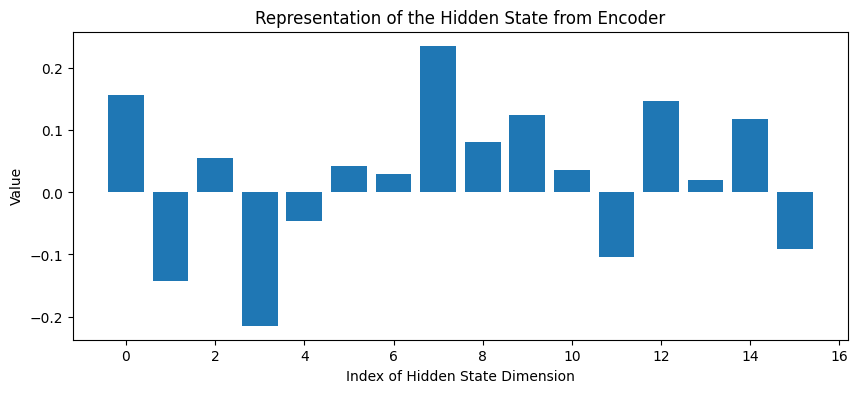

In [16]:
# Tracer le hidden state
plt.figure(figsize=(10, 4))
plt.bar(range(len(hidden_last_layer_np)), hidden_last_layer_np)
plt.xlabel('Index of Hidden State Dimension')
plt.ylabel('Value')
plt.title('Representation of the Hidden State from Encoder')
plt.show()


In [17]:
from sklearn.decomposition import PCA
import numpy as np

# Initialiser l'Encoder (comme défini précédemment)
input_dim = len(vocab_src)
emb_dim = 10
hid_dim = 16
n_layers = 2
dropout = 0.5

encoder = Encoder(input_dim, emb_dim, hid_dim, n_layers, dropout)

# Liste pour stocker les hidden states de chaque phrase
hidden_states = []

# Passer chaque phrase de `train_data` à travers l'Encoder
for src_sentence, _ in train_data:
    # Convertir la phrase en tensor
    src_tensor = sentence_to_tensor(src_sentence, vocab_src).unsqueeze(1)  # (src_len, batch_size)
    
    # Obtenir les hidden states et cell states de l'Encoder
    hidden, cell = encoder(src_tensor)
    
    # Extraire la dernière couche du hidden state
    hidden_last_layer = hidden[-1]  # (batch_size, hid_dim)
    
    # Supposer que la batch_size est 1, on la squeeze pour obtenir une dimension (hid_dim,)
    hidden_last_layer_np = hidden_last_layer.squeeze(0).detach().numpy()
    
    # Ajouter la représentation à la liste des hidden states
    hidden_states.append(hidden_last_layer_np)

# Convertir la liste des hidden states en un tableau numpy
hidden_states_np = np.array(hidden_states)  # Shape (n_sentences, hid_dim)


In [18]:
# Appliquer PCA pour réduire les hidden states à 2 dimensions
pca = PCA(n_components=2)
hidden_states_2d = pca.fit_transform(hidden_states_np)  # Shape (n_sentences, 2)


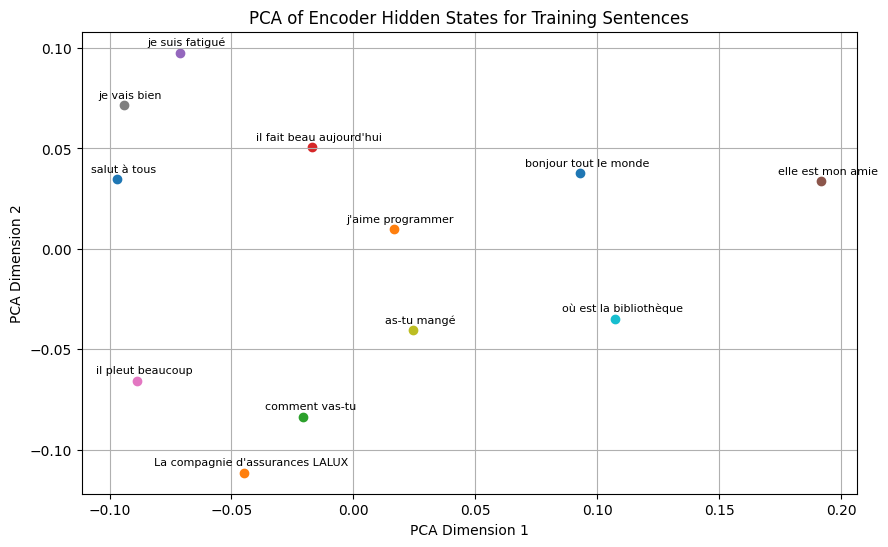

In [19]:
import matplotlib.pyplot as plt

# Créer un graphique pour visualiser les représentations PCA des hidden states
plt.figure(figsize=(10, 6))

# Tracer chaque point correspondant à une phrase
for i, (x, y) in enumerate(hidden_states_2d):
    plt.scatter(x, y, label=train_data[i][0])  # Utiliser la phrase source comme label

# Ajouter des annotations
for i, (x, y) in enumerate(hidden_states_2d):
    plt.annotate(train_data[i][0], (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=8)

# Configuration du graphique
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.title('PCA of Encoder Hidden States for Training Sentences')
plt.grid(True)
plt.show()


2. **Passer le Tenseur dans l'Encoder**
   Passons maintenant ce tenseur à travers l'Encoder pour voir ce qu'il produit.

In [20]:
# 3.2 Définir le Decoder
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)  # (1, batch_size)
        embedded = self.dropout(self.embedding(input))  # (1, batch_size, emb_dim)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))  # (1, batch_size, hid_dim)
        prediction = self.fc_out(output.squeeze(0))  # (batch_size, output_dim)
        return prediction, hidden, cell


### Étape 4 : Définir le Modèle Seq2Seq
Le modèle Seq2Seq combine l'Encoder et le Decoder.

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        trg_len, batch_size = trg.shape
        trg_vocab_size = self.decoder.fc_out.out_features

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)

        input = trg[0, :]  # Début de la phrase cible avec <bos>

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs


### Étape 5 : Entraîner le Modèle
5.1 Paramètres et Initialisation du Modèle

In [22]:
INPUT_DIM = len(vocab_src)
OUTPUT_DIM = len(vocab_tgt)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialiser l'encoder, le decoder et le modèle Seq2Seq
encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

# Optimiseur et fonction de perte
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=vocab_tgt["<pad>"])


Entraînement

In [23]:
N_EPOCHS = 10
CLIP = 1

for epoch in range(N_EPOCHS):
    model.train()
    epoch_loss = 0

    for (src_sentence, tgt_sentence) in train_data:
        # Préparer les données en tenseurs
        src_tensor = sentence_to_tensor(src_sentence, vocab_src).to(device).unsqueeze(1)
        tgt_tensor = sentence_to_tensor(tgt_sentence, vocab_tgt).to(device).unsqueeze(1)

        optimizer.zero_grad()

        output = model(src_tensor, tgt_tensor)
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        tgt = tgt_tensor[1:].view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP)
        optimizer.step()

        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}/{N_EPOCHS}, Loss: {epoch_loss/len(train_data):.4f}')


Epoch 1/10, Loss: 3.4715
Epoch 2/10, Loss: 3.0108
Epoch 3/10, Loss: 2.8009
Epoch 4/10, Loss: 2.2981
Epoch 5/10, Loss: 1.6982
Epoch 6/10, Loss: 1.4346
Epoch 7/10, Loss: 1.1058
Epoch 8/10, Loss: 0.8993
Epoch 9/10, Loss: 0.7050
Epoch 10/10, Loss: 0.5654


### Étape 6 : Traduire des Phrases
6.1 Fonction de Traduction



In [24]:
def translate_sentence(model, sentence, vocab_src, vocab_tgt, device, max_len=50):
    model.eval()
    src_tensor = sentence_to_tensor(sentence, vocab_src).to(device).unsqueeze(1)

    with torch.no_grad():
        hidden, cell = model.encoder(src_tensor)

    trg_indices = [vocab_tgt["<bos>"]]
    trg_tensor = torch.tensor([trg_indices[-1]], dtype=torch.long).to(device)

    for _ in range(max_len):
        with torch.no_grad():
            output, hidden, cell = model.decoder(trg_tensor, hidden, cell)
        
        pred_token = output.argmax(1).item()
        trg_indices.append(pred_token)

        trg_tensor = torch.tensor([pred_token], dtype=torch.long).to(device)

        if pred_token == vocab_tgt["<eos>"]:
            break

    return tensor_to_sentence(trg_indices[1:], vocab_tgt)

def tensor_to_sentence(tensor, vocab):
    inv_vocab = {idx: word for word, idx in vocab.items()}
    words = [inv_vocab.get(idx, "<unk>") for idx in tensor]
    if "<eos>" in words:
        words = words[:words.index("<eos>")]
    return " ".join(words)


6.2 Tester la Traduction


In [25]:
test_sentences = [
    "bonjour tout le monde",
    "j'aime programmer",
    "comment vas-tu",
    "il fait beau aujourd'hui",
    "je suis fatigué",
    "bonjour, il fait beau aujourd'hui"
]

for sentence in test_sentences:
    translation = translate_sentence(model, sentence, vocab_src, vocab_tgt, device)
    print(f'Source: "{sentence}"')
    print(f'Translated: "{translation}"')
    print('-' * 30)


Source: "bonjour tout le monde"
Translated: "hello world"
------------------------------
Source: "j'aime programmer"
Translated: "i love programming"
------------------------------
Source: "comment vas-tu"
Translated: "how you"
------------------------------
Source: "il fait beau aujourd'hui"
Translated: "it's nice a"
------------------------------
Source: "je suis fatigué"
Translated: "i am fine"
------------------------------
Source: "bonjour, il fait beau aujourd'hui"
Translated: "it's nice a"
------------------------------
